<a href="https://colab.research.google.com/github/vlada08/analytics_tasks/blob/master/TEST_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## About data and initial workplan

from README FILE

  Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)
 
      D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

  ### Initial work plan

1. Load data files
2. Make exploratory analysis and Text preprocessing
3. Make necessary transformations
4. Apply (choosen) classification algorithms
5. Visualize word cloud
6. Apply clustering algorithm and visualize clusters
7. Analyze results




In [ ]:
##################################################
## Packages used in for modelling and research ###
##################################################

import os
from google.colab import drive
import csv
import pandas as pd
import re
from collections import defaultdict

import glob
import nltk  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('all')
#nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random


from sklearn.preprocessing import LabelEncoder
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import GridSearchCV

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

## Data loading


In [ ]:
###############################################################
# In this block data can be changed depending on requirements #
###############################################################

# Put directory from which text files will be loaded, mount to the 
os.getcwd()
drive.mount('/content/drive')
# Set default directory
cur_path = '/content/drive/MyDrive/BBC_DATA/bbc/'

#Predefined classes
classes = [
    'business','entertainment', 
    'politics', 'sport', 'tech'
    ]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Read data from folders (folders names are the same as classes, 

data = defaultdict(list)

for dirs, _ ,filenames in os.walk(cur_path):
  dir_name = os.path.basename(dirs).lower()
  if dir_name in classes:
      for files in filenames:
        data['Document_Id'].append(dirs)
        #Get root
        file_name = os.path.splitext(files)[0]
        data['Id'].append(file_name)
        data['Category'].append(dir_name)
        
        #Load text from the files
        path = os.path.join(dirs, files)
        with open(path ,'r',encoding= 'unicode_escape') as file:
                data['Text'].append(file.read())

  # Check what wasn't included (for check)
  else:
    print('Not included: ',filenames)

# Convert dict to dataframe    
df = pd.DataFrame.from_dict(data)
print('Rows example: ')
print(df.head(3) )  

# Check documents freq by Categories, check for duplicates

print('Documents count by Categories: ')
print(df['Category'].value_counts())

Not included:  ['README.TXT']
Rows example: 
Documents count by Categories: 
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64


Analysis


In [ ]:
def check_nan(df):
  '''
  Used to check NaN values in dataframe.
  Output - rows with NaN values
  '''
  is_NaN = df.isnull()
  row_has_NaN = is_NaN.any(axis=1)
  rows_with_NaN = df[row_has_NaN]
  return rows_with_NaN


def check_duplicates(df):
  '''
  Used to check for duplicates and delete duplicated rows.
  Check if one row belong to more than one Category
  
  Output - Cleaned dataframe
  '''
  unique_text = df['Text'].unique()
  if len(unique_text) != len(df):
    print('There are duplicates in Text. Some examples: ')
    print(df[df.Text.duplicated(keep=False)]\
                .sort_values('Text'))
    #Make unique by Category and Text
    unique_cat_text = len(df[['Category','Text']]\
                                .drop_duplicates()) 
    
    if unique_cat_text == len(unique_text):
      # Remove duplicates (update numbers)
      df = df.drop_duplicates(subset='Text', keep="last")\
                                .reset_index(drop=True)

    else:
      print('One text belong to more than one category')
  return df


def preprocessing(
    df,
    text_col,
    text_after,
    stopwords):
  
  '''
  Text preprocessing:
    - Remove unnecessary symbols, numbers
    - Remove stopwords
    - Add Tokenized column (? if necessary)
  '''

  # Converting to Lowercase
  df[text_after] = df[text_col].\
                        apply(lambda x: str(x).lower())
                  
  # Remove line breaks
  df = df.replace(r'\n', ' ', regex = True)

  #Remove special characters (not letters,numbers)
  #'[^A-Za-z0-9]+'
  
  df[text_after] = df[text_after].\
                        apply(lambda x: re.sub("[!@#$;:!*%)(&^~',-_\"]", '', str(x)))

  # Remove single characters
  df[text_after] = df[text_after].\
                        apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', str(x)))                     
  #Remove all numbers (?)
  df[text_after] = df[text_after].\
                        apply(lambda x: re.sub(r'[0-9]', ' ', str(x))) 
  #Remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
  df[text_after] = df[text_after].\
                        apply(lambda x: pattern.sub('', x) )  

  # Remove multiple spaces in content
  df[text_after] = df[text_after].\
                        apply(lambda x: re.sub(r"\s+", " ", str(x)))   
  # Tokenize
  df[text_after + 'Tokenized'] = df[text_after].\
                        apply(lambda x: word_tokenize(x)) 
  return df


  

def stemming(
    df,
    text_col,
    text_after):
  '''
  # https://www.guru99.com/stemming-lemmatization-python-nltk.html
  # Stemming and Lemmatization
  '''
  ps = PorterStemmer ()
  n = 0 
  for document in df[text_col]:
    document = document.split()
    document = [ps.stem(word) for word in document]
    document = ' '.join(document)
    df.loc[n,text_after] = document
    n += 1
  #print(n)
  return df

def lemmitiz(
    df,
    text_col,
    text_after):
  stemmer = WordNetLemmatizer()
  n = 0 
  for document in df[text_col]:
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    df.loc[n,text_after] = document
    n += 1
  #print(n)
  return df

In [ ]:
df = check_duplicates(df)
print('Total rows count after deleting duplciates: '+ str(len(df)))
print('Are there any rows with NaN values: ')
print(check_nan(df))

There are duplicates in Text. Some examples: 
                                       Document_Id   Id  Category  \
1513      /content/drive/MyDrive/BBC_DATA/bbc/tech  165      tech   
1703      /content/drive/MyDrive/BBC_DATA/bbc/tech  166      tech   
2108  /content/drive/MyDrive/BBC_DATA/bbc/politics  059  politics   
2204  /content/drive/MyDrive/BBC_DATA/bbc/politics  298  politics   
1991  /content/drive/MyDrive/BBC_DATA/bbc/politics  291  politics   
...                                            ...  ...       ...   
1625      /content/drive/MyDrive/BBC_DATA/bbc/tech  027      tech   
1482      /content/drive/MyDrive/BBC_DATA/bbc/tech  312      tech   
1442      /content/drive/MyDrive/BBC_DATA/bbc/tech  090      tech   
1657      /content/drive/MyDrive/BBC_DATA/bbc/tech  313      tech   
1410      /content/drive/MyDrive/BBC_DATA/bbc/tech  094      tech   

                                                                                                                             

## Text preprocessing
Main steps:
1. Identify titles and text
2. Remove numbers, special characteres and unwanted spaces (using reg expr)
3. Remove all single characters (e.g. O'Sullivan- remove s) (using reg expr)
4. Stemming and Lemmatization (find roots, identify semantically similar words which sintat.different)
5. Remove stop words ?
5. Convert Text to numbers (Vectorization)

In [ ]:
#Identify Titles and texts
text = df['Text'].str.split('\n', n = 2, expand = True) 
df['Title'] =  text[0]
df['Text2'] = text[2]

pd.options.display.max_colwidth = 200

# After deeper analysis we can change stopwords list
stopwords_list = stopwords.words('english')

df_after = preprocessing(df = df,
                         text_col = 'Text2',
                         text_after = 'Text_After',
                         stopwords = stopwords_list)


df_after = stemming(df_after,'Text_After','Text_Final_Stem')
#df_after.head(5)

,Document_Id,Id,Category,Text,Title,Text2,Text_After,Text_AfterTokenized,Text_Final_Stem
0,/content/drive/MyDrive/BBC_DATA/bbc/sport,007,sport,"O'Sullivan commits to Dublin race Sonia O'Sullivan will seek to regain her title at the Bupa Great Ireland Run on 9 April in Dublin. The 35-year-old was beaten into fourth at last year's event, ...",O'Sullivan commits to Dublin race,"Sonia O'Sullivan will seek to regain her title at the Bupa Great Ireland Run on 9 April in Dublin. The 35-year-old was beaten into fourth at last year's event, having won it a year earlier. ""I un...",sonia osullivan seek regain title bupa great ireland run april dublin yearold beaten fourth last years event year earlier understand shes solid winters training australia recovering minor injury s...,"[sonia, osullivan, seek, regain, title, bupa, great, ireland, run, april, dublin, yearold, beaten, fourth, last, years, event, year, earlier, understand, shes, solid, winters, training, australia,...",sonia osullivan seek regain titl bupa great ireland run april dublin yearold beaten fourth last year event year earlier understand she solid winter train australia recov minor injuri said race dir...
1,/content/drive/MyDrive/BBC_DATA/bbc/sport,042,sport,"Radcliffe enjoys winning comeback Paula Radcliffe made a triumphant return to competitive running with victory in the New York Marathon. The Briton, running for the first time since dropping out...",Radcliffe enjoys winning comeback,"Paula Radcliffe made a triumphant return to competitive running with victory in the New York Marathon. The Briton, running for the first time since dropping out of the Olympic marathon and 10,000...",paula radcliffe made triumphant return competitive running victory new york marathon briton running first time since dropping olympic marathon held kenyan susan chepkemei thrilling finish pair loc...,"[paula, radcliffe, made, triumphant, return, competitive, running, victory, new, york, marathon, briton, running, first, time, since, dropping, olympic, marathon, held, kenyan, susan, chepkemei, t...",paula radcliff made triumphant return competit run victori new york marathon briton run first time sinc drop olymp marathon held kenyan susan chepkemei thrill finish pair lock togeth last mile rad...
2,/content/drive/MyDrive/BBC_DATA/bbc/sport,044,sport,White admits to Balco drugs link Banned American sprinter Kelli White says she knowingly took steroids given to her by Bay Area Lab Co-Operative (Balco) president Victor Conte. Conte faces a fed...,White admits to Balco drugs link,Banned American sprinter Kelli White says she knowingly took steroids given to her by Bay Area Lab Co-Operative (Balco) president Victor Conte. Conte faces a federal trial next year on charges of...,banned american sprinter kelli white says knowingly took steroids given bay area lab cooperative balco president victor conte conte faces federal trial next year charges distributing steroids tax ...,"[banned, american, sprinter, kelli, white, says, knowingly, took, steroids, given, bay, area, lab, cooperative, balco, president, victor, conte, conte, faces, federal, trial, next, year, charges, ...",ban american sprinter kelli white say knowingli took steroid given bay area lab cooper balco presid victor cont cont face feder trial next year charg distribut steroid tax evas white said first tr...
3,/content/drive/MyDrive/BBC_DATA/bbc/sport,038,sport,"Radcliffe proves doubters wrong This won't go down as one of the greatest marathons of Paula's career. But as a test of character, it was the toughest race she's ever taken part in. A win in the...",Radcliffe proves doubters wrong,"This won't go down as one of the greatest marathons of Paula's career. But as a test of character, it was the toughest race she's ever taken part in. A win in the New York marathon doesn't make u...",wont go one greatest marathons paulas career test character toughest race shes ever taken part win new york marathon doesnt make disappointment athens shap

In [ ]:
df_after = lemmitiz(df_after,'Text_After','Text_Final')

# Check for NaN after modifications
print('Are the any Nan values in dataframe')
print(check_nan(df_after))

# Before decide what column to choose, review results
df_after[['Text_After','Text_Final_Stem','Text_Final']].head(5)
# Lemmitiz works better - will use 'Text_Final' column

Are the any Nan values in dataframe
Empty DataFrame
Columns: [Document_Id, Id, Category, Text, Title, Text2, Text_After, Text_AfterTokenized, Text_Final_Stem, Text_Final]
Index: []


,Text_After,Text_Final_Stem,Text_Final
0,sonia osullivan seek regain title bupa great ireland run april dublin yearold beaten fourth last years event year earlier understand shes solid winters training australia recovering minor injury s...,sonia osullivan seek regain titl bupa great ireland run april dublin yearold beaten fourth last year event year earlier understand she solid winter train australia recov minor injuri said race dir...,sonia osullivan seek regain title bupa great ireland run april dublin yearold beaten fourth last year event year earlier understand shes solid winter training australia recovering minor injury sai...
1,paula radcliffe made triumphant return competitive running victory new york marathon briton running first time since dropping olympic marathon held kenyan susan chepkemei thrilling finish pair loc...,paula radcliff made triumphant return competit run victori new york marathon briton run first time sinc drop olymp marathon held kenyan susan chepkemei thrill finish pair lock togeth last mile rad...,paula radcliffe made triumphant return competitive running victory new york marathon briton running first time since dropping olympic marathon held kenyan susan chepkemei thrilling finish pair loc...
2,banned american sprinter kelli white says knowingly took steroids given bay area lab cooperative balco president victor conte conte faces federal trial next year charges distributing steroids tax ...,ban american sprinter kelli white say knowingli took steroid given bay area lab cooper balco presid victor cont cont face feder trial next year charg distribut steroid tax evas white said first tr...,banned american sprinter kelli white say knowingly took steroid given bay area lab cooperative balco president victor conte conte face federal trial next year charge distributing steroid tax evasi...
3,wont go one greatest marathons paulas career test character toughest race shes ever taken part win new york marathon doesnt make disappointment athens shape form offer hope reassurance next year p...,wont go one greatest marathon paula career test charact toughest race she ever taken part win new york marathon doesnt make disappoint athen shape form offer hope reassur next year paula last expe...,wont go one greatest marathon paulas career test character toughest race shes ever taken part win new york marathon doesnt make disappointment athens shape form offer hope reassurance next year pa...
4,london marathon organisers hoping banned athlete susan chepkemei still take part years race april chepkemei suspended competition end year athletics kenya failing report national training camp wat...,london marathon organis hope ban athlet susan chepkemei still take part year race april chepkemei suspend competit end year athlet kenya fail report nation train camp watch close said london race ...,london marathon organiser hoping banned athlete susan chepkemei still take part year race april chepkemei suspended competition end year athletics kenya failing report national training camp watch...


Before run classsification models it would be good to see words distribution in differnt clusters to understand if we need any additionals actions to be done.

business: 
Total words number: 3824
[('bn', 217), ('said', 203), ('firm', 144), ('year', 117), ('bank', 81), ('company', 77), ('sale', 74), ('share', 70), ('profit', 69), ('new', 69)]
entertainment: 
Total words number: 3552
[('film', 179), ('award', 113), ('star', 99), ('year', 97), ('best', 86), ('said', 78), ('show', 72), ('new', 65), ('music', 59), ('singer', 51)]
politics: 
Total words number: 3275
[('said', 175), ('labour', 110), ('mr', 106), ('minister', 99), ('election', 98), ('blair', 95), ('party', 94), ('would', 89), ('government', 84), ('uk', 83)]
sport: 
Total words number: 3737
[('england', 103), ('win', 89), ('said', 86), ('world', 84), ('champion', 84), ('six', 81), ('year', 78), ('cup', 78), ('first', 77), ('nation', 67)]
tech: 
Total words number: 3113
[('game', 88), ('people', 77), ('new', 72), ('mobile', 72), ('firm', 66), ('phone', 66), ('year', 62), ('technology', 55), ('could', 52), ('said', 50)]


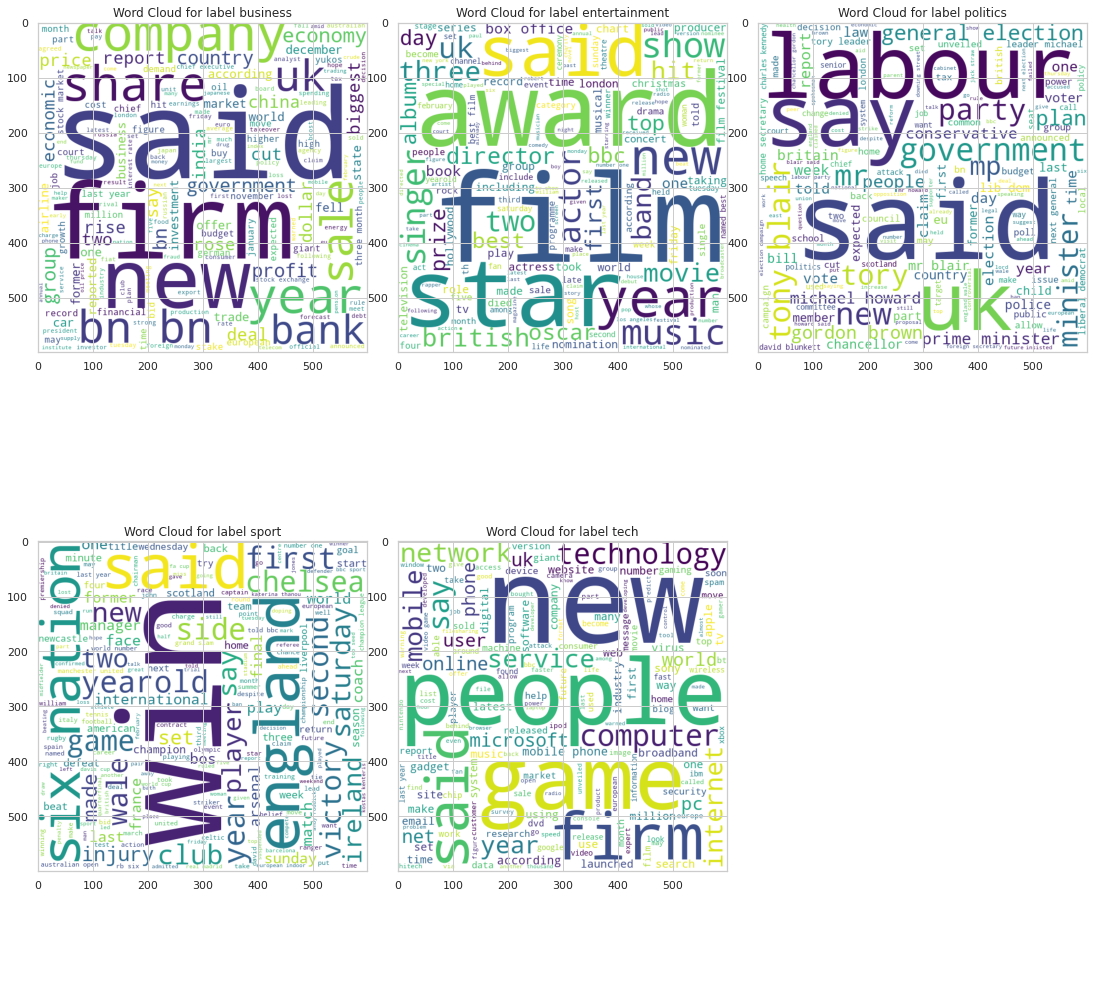

In [ ]:
# Most frequent words by clusters - WordsClouds
from collections import Counter
fig,ax = plt.subplots(2, 3, figsize=(15, 15))
i = 0
for x in classes:
  df = df_after.loc[df_after['Category'] == x]
  text = df['Text_Final'].to_string()

  pattern = re.findall(r'\b[a-z]{2,35}\b', text)
  #split_it = text.split()
  Count_words = Counter(pattern)
  most_occur = Count_words.most_common(10)
  print(x+': ')
  print('Total words number: '+ str(len(Count_words.values())))
  print(most_occur)
  comment_words = ''
  comment_words += " ".join(pattern)+" "
  wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
  
  j,k = i//3, i%3
  ax[j,k].imshow(wordcloud)
  ax[j,k].set_title(f'Word Cloud for label {x}')
  i+=1
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
  
  #can add visualization; think about uk-england, year,say,said

In [ ]:
# Create labels
label_enc = LabelEncoder()
df_after['label'] = label_enc.fit_transform(df_after['Category'])
df_after['label'].value_counts()


3    505
0    503
2    403
1    369
4    347
Name: label, dtype: int64

In [ ]:
# Vectorize (TFIDF - comparing words frequency amongst documents)
vectorizer = TfidfVectorizer(input='content', ngram_range=(1, 3), min_df=0.05)
text_vector = vectorizer.fit_transform(df_after.Text_After)

features = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Classification model

In [ ]:
# Start model training
SEED = 42
random.seed(SEED)

X = text_vector
y = df_after.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
tags = df_after.Category
#from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)

# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
SVM_pred = SVM.predict(X_test)

# Classifier - Random Forest
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 
rf_pred = classifier.predict(X_test)


print('Naive Bayes Accuracy: ', mnb.score(X_test, y_test))
print(classification_report(y_test, mnb_pred))

print("SVM Accuracy ",accuracy_score(SVM_pred, y_test))
print(classification_report(y_test, SVM_pred))

print("RF Accuracy ",accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Naive Bayes Accuracy:  0.9586466165413534
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       129
           1       0.90      0.96      0.93        76
           2       0.96      0.97      0.97       102
           3       0.98      0.99      0.99       134
           4       0.98      0.91      0.94        91

    accuracy                           0.96       532
   macro avg       0.96      0.96      0.96       532
weighted avg       0.96      0.96      0.96       532

SVM Accuracy  0.9605263157894737
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       129
           1       0.92      0.95      0.94        76
           2       0.95      0.97      0.96       102
           3       0.98      1.00      0.99       134
           4       0.98      0.92      0.95        91

    accuracy                           0.96       532
   macro avg       0.96      0.96      0.96       532
we

In [ ]:
# Save model (svm)
import pickle
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(SVM,picklefile)


In [ ]:
# Rerun model (svm)
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

y_pred2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2)) 

[[100   0   4   2   0]
 [  1  62   0   0   0]
 [  1   0  80   1   0]
 [  0   0   0 104   0]
 [  1   2   0   0  68]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       106
           1       0.97      0.98      0.98        63
           2       0.95      0.98      0.96        82
           3       0.97      1.00      0.99       104
           4       1.00      0.96      0.98        71

    accuracy                           0.97       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.97      0.97      0.97       426

0.971830985915493


## Clustering model

In [ ]:

# K-meand clustering
k=5
km = KMeans(n_clusters=k,init= 'k-means++').fit(X)
clusters = km.predict(X)
labels = km.labels_
df_after['Cluster_Km'] = labels
print("K-Means clustering")
print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")

#Hierarchical clustering
dist = 1 - cosine_similarity(X)
linked = linkage(dist, 'ward')
'''
plt.figure(figsize=(12, 7))
dendrogram(linked)
plt.show()
'''
print("Hierarchical clustering: ")
b3 = cut_tree(linked, n_clusters= k)
print(f"Silhouette coefficient: {silhouette_score(X, b3):0.2f}")

K-Means clustering
Silhouette coefficient: 0.03


In [ ]:
df_after['Cluster_Hr'] = b3

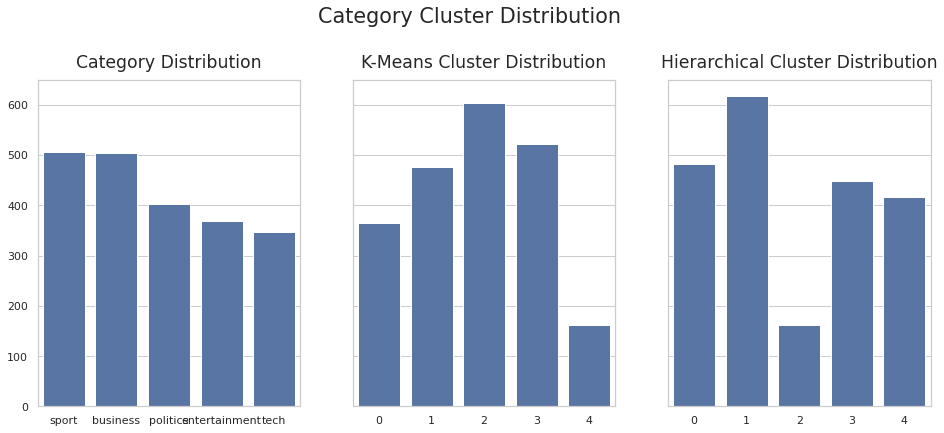

In [ ]:
import seaborn as sns; sns.set_theme(style="whitegrid")
category_distrib = df_after['Category'].value_counts()
cluster_distrib_km = df_after['Cluster_Km'].value_counts()
cluster_distrib_hr = df_after['Cluster_Hr'].value_counts()

# Plot both
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,6))
fig.suptitle('Category Cluster Distribution', fontsize='xx-large', y=1.05)
axs[0].set_title("Category Distribution", fontsize='x-large', y=1.02)
axs[1].set_title("K-Means Cluster Distribution", fontsize='x-large', y=1.02)
axs[2].set_title("Hierarchical Cluster Distribution", fontsize='x-large', y=1.02)

sns.barplot(x=category_distrib.index, y=category_distrib.values, ax=axs[0], color='b')
sns.barplot(x=cluster_distrib_km.index, y=cluster_distrib_km.values, ax=axs[1], color='b')
sns.barplot(x=cluster_distrib_hr.index, y=cluster_distrib_hr.values, ax=axs[2], color='b')

In [2]:
import numpy as np
def get_top_keywords(data, 
                     df,
                     col,
                     labels,
                     n_terms):
    df = pd.DataFrame(data.todense()).groupby(df[col]).count()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
#get_top_keywords(X, df_after,'Cluster_Hr', vectorizer.get_feature_names(), 10)
#get_top_keywords(X, df_after,'Cluster_Km', vectorizer.get_feature_names(), 10)

